# Praca domowa nr 5

Adrianna Grudzień\
8 maja 2021 r. 

W ramach pracy domowej z przedmiotu Warsztaty badawcze przeanalizowałam, na jakiej podstawie sieć neuronowa wygenerowała predykcje (na podstawie metod XAI - algorytmu `GRAD-CAM` oraz `LIME`). Dokonałam analiz na obrazkach zarówno dobrze, jak i źle zaklasyfikowanych.

In [1]:
import numpy as np
import math

import matplotlib.cm as cm
from tensorflow import keras
from keras.preprocessing.image import load_img
from IPython.display import Image, display
from keras.preprocessing.image import img_to_array

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing import image


### Wczytanie modelu
Na potrzeby tego zadania skorzystam z modelu **VGG16**.
Wczytanie modelu:

In [26]:
model = VGG16(weights='imagenet')
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Jak wygląda model
Wejście ma stały rozmiar obrazu RGB 224 x 224. Obraz przepuszczany jest przez stos warstw konwolucyjnych, w których zastosowano filtry z bardzo małym polem recepcyjnym: 3 × 3 (czyli najmniejszym rozmiarem umożliwiającym uchwycenie pojęcia lewa / prawa, góra / dół, środek ). W jednej z konfiguracji wykorzystuje również filtry splotu 1 × 1, które można postrzegać jako liniową transformację kanałów wejściowych (po której następuje nieliniowość).

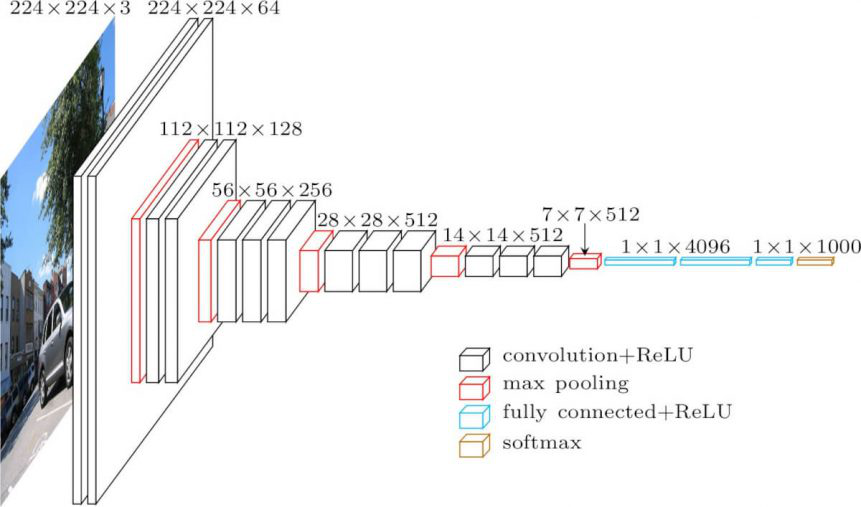

In [38]:
load_img("vgg16-neural-network.jpg")

https://neurohive.io/en/popular-networks/vgg16/

### Obrazki
Tematem przewodnim tej pracy jest analiza kościołów. Jeden spośród nich został dobrany tak, aby swoim wyglądem przypominał inny obiekt - łódź. 

In [27]:
def przygotujZdjecie(plik):
    img = load_img(plik)
    img = load_img(plik, target_size=(224,224))
    display(img)
    img = img_to_array(img)
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    img = preprocess_input(img)
    return img

def opiszZdjecie(plik):
    img = przygotujZdjecie(plik)
    pred_img = model.predict(img)
    labels = decode_predictions(pred_img)[0]
    for info in labels:
        print(info[1],round(info[2]*100, 2),'%')
    print()

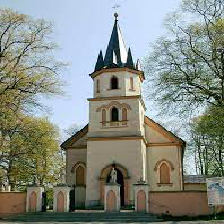

church 74.87 %
monastery 22.28 %
bell_cote 2.71 %
dome 0.05 %
palace 0.01 %



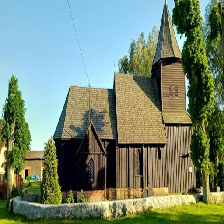

church 84.33 %
bell_cote 5.28 %
castle 2.13 %
worm_fence 1.92 %
picket_fence 1.33 %



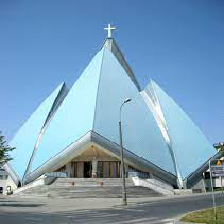

schooner 11.59 %
church 10.83 %
solar_dish 9.01 %
dome 6.9 %
radio_telescope 6.38 %



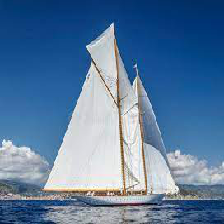

schooner 94.56 %
yawl 4.98 %
pirate 0.24 %
trimaran 0.12 %
catamaran 0.08 %



In [50]:
opiszZdjecie("kosciol.jpeg")
opiszZdjecie("kosciol2.jpg")
opiszZdjecie("kosciol_bez_wiezyczki.jpeg")
opiszZdjecie("shooner.jpeg")

Jak widać, jeden z kościołów został zaklasyfikowany niepoprawnie - został uznany za łódź. Dla porównania zamieściłam także zdjęcie prawdziwej łodzi.

### Algorytm `GRAD-CAM`

In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [43]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

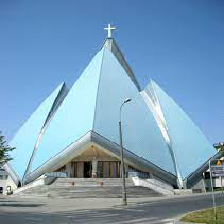

Predicted: ('n04147183', 'schooner', 0.1158918)


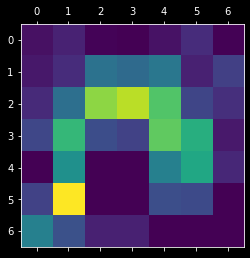

In [48]:
import tensorflow as tf
import matplotlib.pyplot as plt
# Prepare image
img_array = przygotujZdjecie("kosciol_bez_wiezyczki.jpeg")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds)[0][0])

last_conv_layer_name = "block5_pool"
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


https://keras.io/examples/vision/grad_cam/

To zdjęcie zostało źle rozpoznane. Przyjrzyjmy się innej wizualizacji tego, na co uwaga była szczególnie zwracana:

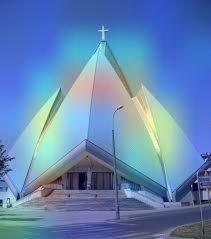

In [49]:
save_and_display_gradcam("kosciol_bez_wiezyczki.jpeg", heatmap)

W tym przypadku ważny był kształt dachu kościoła - jest łudząco podobny do łodzi. Wygląda na to, że model ostatecznie zasugerował się również tłem obiektu - błękit i jednorodność nieba podobne są do tego widywanego w obecności łodzi na morzu.

Dla porównania zamieściłam zdjęcie pradziwej łodzi, łudząco podobnej do wcześniejszego kościoła:

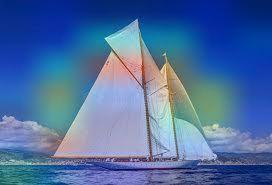

In [47]:
save_and_display_gradcam("shooner.jpeg", heatmap)

Pod uwagę brane są podobne elementy obrazka.


### Algorytm `LIME`

In [42]:
from skimage.segmentation import mark_boundaries

In [7]:
import lime
from lime import lime_image

In [15]:
def plot_lime_top_explanations(model, file):
    img_array = img_to_array(load_img(file, target_size=(224,224))).astype('double')
    fig_name="LIME"

    top_preds_count = 3
    image_columns = 3
    image_rows = math.ceil(top_preds_count / image_columns)
    
    explainer = lime_image.LimeImageExplainer(verbose = False)
    explanation = explainer.explain_instance(
        img_array, 
        classifier_fn = model.predict, 
        top_labels=3, 
        hide_color=0, 
        num_samples=1000
    )
    
    preds = model.predict(np.expand_dims(img_array, axis=0))
    top_preds_indexes = np.flip(np.argsort(preds))[0,:top_preds_count]
    top_preds_values = preds.take(top_preds_indexes)
    labels = decode_predictions(preds)[0]
    
    plt.style.use('dark_background')
    fig, axes = plt.subplots(image_rows, image_columns, figsize=(image_columns * 5, image_rows * 5))
    [ax.set_axis_off() for ax in axes.flat]
    
    for i, (index, value, name, ax) in \
        enumerate(zip(top_preds_indexes, top_preds_values, labels, axes.flat)):
        
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[i], 
            positive_only=False, 
            num_features=5, 
            hide_rest=False
        )
        
        subplot_title = "{}. class: {} pred: {:.3f}".format(i + 1, name[1], value)
        ax.imshow(mark_boundaries(temp / 255, mask))
        ax.set_title(subplot_title, pad=20)
    
    
    if fig_name:
        plt.savefig(fig_name)
    plt.show()

https://towardsdatascience.com/knowing-what-and-why-explaining-image-classifier-predictions-680a15043bad

  0%|          | 0/1000 [00:00<?, ?it/s]

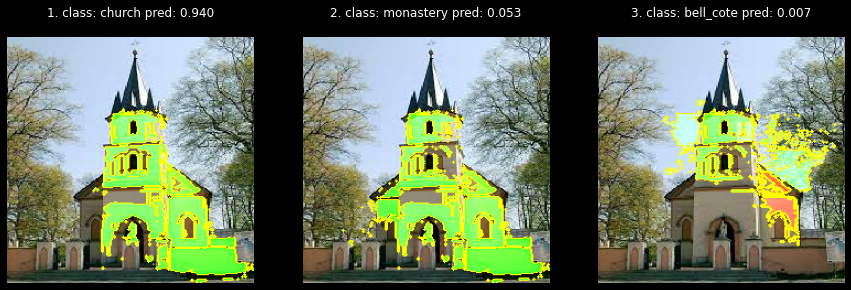

In [38]:
plot_lime_top_explanations(model, "kosciol.jpeg")

Jak widać, najważniejsza w tym przypadku do rozpoznania **kościoła** jest wieżyczka, wejście oraz mur. Dla **klasztoru** kryteria są bardzo podobne. W przypadku **dzwonnicy**, uwaga przyłożona jest do samego szczytu wieżyczki, która swoim kształtem rzeczywiście przypomina dzwonnicę (ważne okazuje się również tło dzwonnicy - niebo, a nie np. inna zabudowa.)

  0%|          | 0/1000 [00:00<?, ?it/s]

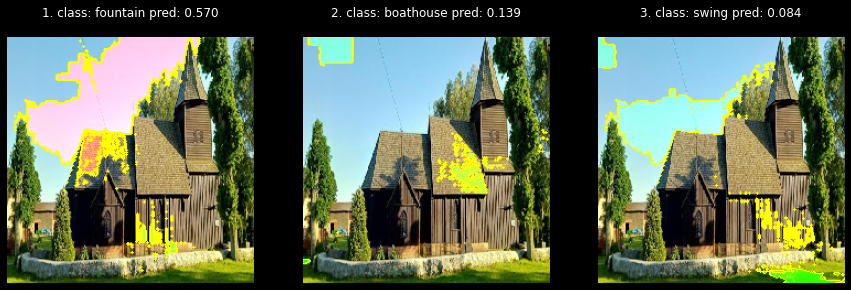

In [39]:
plot_lime_top_explanations(model, "kosciol2.jpg")

W tym przypadku model bardzo się pomylił, biorąc drut telegraficzny za wodę wytryskującą z **fontanny**. W pozostałych przewidywaniach również nie znalazł poprawnej odpowiedzi mówiącej, że na obrazku znajduje się kościół. 

  0%|          | 0/1000 [00:00<?, ?it/s]

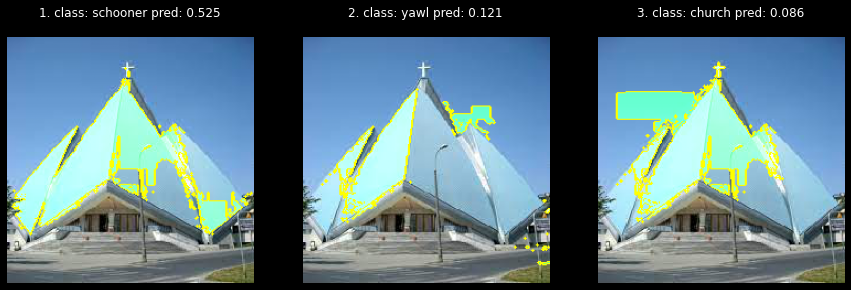

In [40]:
plot_lime_top_explanations(model,"kosciol_bez_wiezyczki.jpeg")

To miało być zdjęcie zmyłkowe - kościół w kształcie **łodzi**. Na pierwszym miejscu przewidywań rzeczywiście pojawiła się łódź (kolor i kształt dachu do złudzenia przypomina żagle). Dla klasy yawl ważny był fragment nieba i nieco zawężona część dachu (prawdopodobnie wynika to z różnic w budowie łodzi shooner i yawl). Odpowiedź **kościół** jest dopiero na 3. miejscu (model słusznie zauważył, że krzyż to dobre kryterium rozpoznania obiektów sakralnych).

  0%|          | 0/1000 [00:00<?, ?it/s]

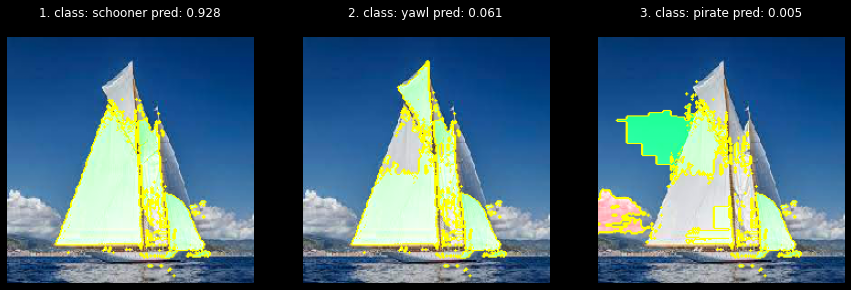

In [41]:
plot_lime_top_explanations(model, "shooner.jpeg")

Dla porównania kościoła-łodzi, zamieszczam zdjęcie prawdziwej łodzi. W rozpoznawaniu obiektu podobnie brany jest pod uwagę kształt żagli, a także otaczające tło (niebo i chmurki).

### Wnioski
Główną różnicą w wykorzystaniu algorytmów `GRAD-CAM` i `LIME` był czas kompilacji funkcji generujących obrazki. W przypadku LIME był on znacznie dłuższy. Jednocześnie efekt wydaje się bardziej zadowalający i dokładny.

Inne źródła, z których korzystałam:
- https://towardsdatascience.com/how-to-use-a-pre-trained-model-vgg-for-image-classification-8dd7c4a4a517